In [1]:
import xarray as xr
import numpy as np
from scipy.io import loadmat
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seastar as ss
import seastar.oscar
import seastar.retrieval
import cartopy.crs as ccrs
import re
import os
from scipy import interpolate

In [3]:
# Data load and pre-processing
#oscar_path = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Metasensing\\OSCAR\\Brest_Sample_Oct_13_2022_precompute\\"
oscar_path = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Metasensing\\OSCAR\\May22_full_precompute\\"
#oscar_path = "D:\\data\\oscar\\Brest_Sample_Oct_13_2022\\"
file_time_triplets = ss.utils.tools.find_file_triplets(oscar_path)

print('OSCAR L1 processing')
print('-------------------')
print('File path :', oscar_path)
print('-------------------')
for i in range(len(file_time_triplets)):
    print('File index :', i, ',', 'Aquisition time :', file_time_triplets[i][0], ',', 'File list indices :', file_time_triplets[i][1])

# Match tracks in the star pattern from track names and times in the DAR_v6.0 to file aquisition times
star_pattern_tracks={
    'Track_11' : 4,
    'Track_12' : 5,
    'Track_13' : 6,
    'Track_14' : 7,
    'Track_15' : 8,
    'Track_16' : 9,
    'Track_17' : 10,
    'Track_18' : 11}


OSCAR L1 processing
-------------------
File path : D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\May22_full_precompute\
-------------------
File index : 0 , Aquisition time : 20220522T052218 , File list indices : [0, 1, 2]
File index : 1 , Aquisition time : 20220522T053942 , File list indices : [3, 4, 5]
File index : 2 , Aquisition time : 20220522T054805 , File list indices : [6, 7, 8]
File index : 3 , Aquisition time : 20220522T055458 , File list indices : [9, 10, 11]
File index : 4 , Aquisition time : 20220522T062018 , File list indices : [12, 13, 14]
File index : 5 , Aquisition time : 20220522T062620 , File list indices : [15, 16, 17]
File index : 6 , Aquisition time : 20220522T063239 , File list indices : [18, 19, 20]
File index : 7 , Aquisition time : 20220522T063906 , File list indices : [21, 22, 23]
File index : 8 , Aquisition time : 20220522T064459 , File list indices : [24, 25, 26]
File index : 9 , Aquisition time : 20220522T065108 , File list indices : [27, 28, 29]
File i

In [5]:
ds_l1_star = dict()
ds_l2_star = dict()
for track in star_pattern_tracks.keys(): # Loop through star pattern tracks
    file_index = star_pattern_tracks[track]
    ds = ss.utils.readers.load_OSCAR_data(oscar_path, file_time_triplets[file_index][1])
    antenna_ident = ss.utils.tools.identify_antenna_location_from_filename(oscar_path, file_time_triplets[file_index][1])
    #antenna_ident = ss.utils.tools.antenna_idents(ds)
    ds = ss.oscar.level1.fill_missing_variables(ds, antenna_ident)
    print('Processing file index',file_index)
    # L1 processing
    for i in list(ds.keys()):
        ds[i] = ss.oscar.level1.check_antenna_polarization(ds[i])
        ds[i] = ss.oscar.level1.compute_multilooking_Master_Slave(ds[i], window=7)
        ds[i]['Baseline'] = ss.oscar.level1.compute_antenna_baseline(0.2)
        ds[i] = ss.oscar.level1.compute_antenna_azimuth_direction(ds[i], antenna=antenna_ident[list(ds.keys()).index(i)])
        ds[i] = ss.oscar.level1.compute_time_lag_Master_Slave(ds[i], options='from_SAR_time')
        ds[i] = ss.oscar.level1.compute_radial_surface_velocity(ds[i])
    #Build L1 dataset
    dsl1 = ss.oscar.level1.merge_beams(ds, antenna_ident)
    # Generating geophysical data fields for GMF doppler computation, data taken from DAR
    u10 = 5 # wind speed
    wind_direction = 25 # wind direction
    aux = ss.oscar.level1.init_auxiliary(dsl1,u10,wind_direction)
    # Compute RSC
    dsl1 = ss.oscar.level1.compute_radial_surface_current(dsl1, aux, gmf='mouche12')
    #L2 Processing
    # Initialise l2 dataset
    dsl2=ss.oscar.level1.init_level2(dsl1)
    # Compute current magnitude and direction
    dsl2=seastar.retrieval.level2.compute_current_magnitude_and_direction(dsl1, dsl2)
    # Compute current vectors
    dsl2['CurrentVectorUComponent'], dsl2['CurrentVectorVComponent'] =\
    ss.utils.tools.currentVelDir2UV(dsl2['CurrentMagnitude'], dsl2['CurrentDirection'])
    ds_l2_star[track] = dsl2
    ds_l1_star[track] = dsl1





Processing file index 4
Processing file index 5


C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\xarray\core\computation.py:733: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)


Processing file index 6
Processing file index 7
Processing file index 8
Processing file index 9
Processing file index 10


C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\xarray\core\computation.py:733: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)


Processing file index 11


In [ ]:
def compute_incidence_angle_flag(ds_level1, inc_min=20, inc_max=57):
    mask=dict()
    for image in ds_level1.Antenna.data:
        inc = ds_level1.sel(Antenna=image).IncidenceAngleImage
        mask[image] = (inc > inc_min) & (inc < inc_max)
    inc_angle_flag = np.full(mask[dsl1.Antenna.data[0]].shape, False)
    for image in dsl1.Antenna.data:
        inc_angle_flag = inc_angle_flag | mask[image]
    
    return inc_angle_flag

In [ ]:
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)

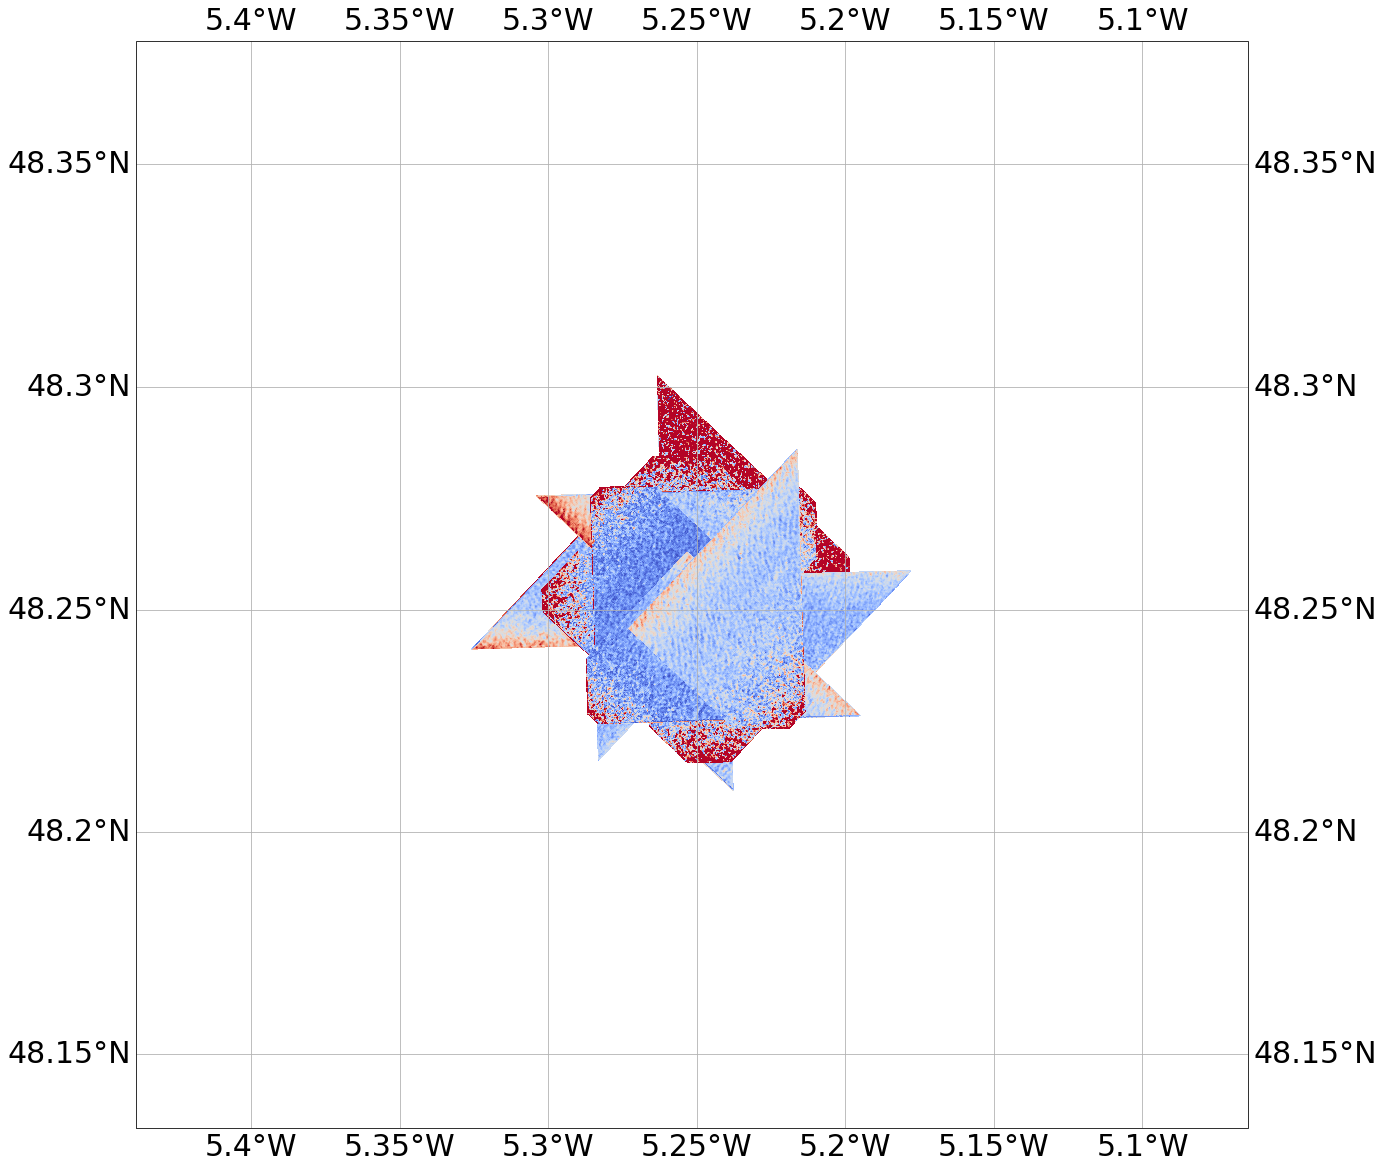

In [6]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
for track in ds_l2_star.keys():
    img=ds_l2_star[track].CurrentMagnitude
    img_masked = np.ma.masked_where(img != 0, img)
    img.where(img_masked).plot(
        y='latitude', x='longitude',
        robust=True,
        cmap='coolwarm',
        vmin=0, vmax=2,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )

gl=ax.gridlines(draw_labels=True)
gl.xlabel_style = {'size': 30, 'color': 'black'}
gl.ylabel_style = {'size': 30, 'color': 'black'}
#ax.set_extent([-5.17, -5.1, 48.37, 48.5], crs=ccrs.PlateCarree()) plt.show()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(40)

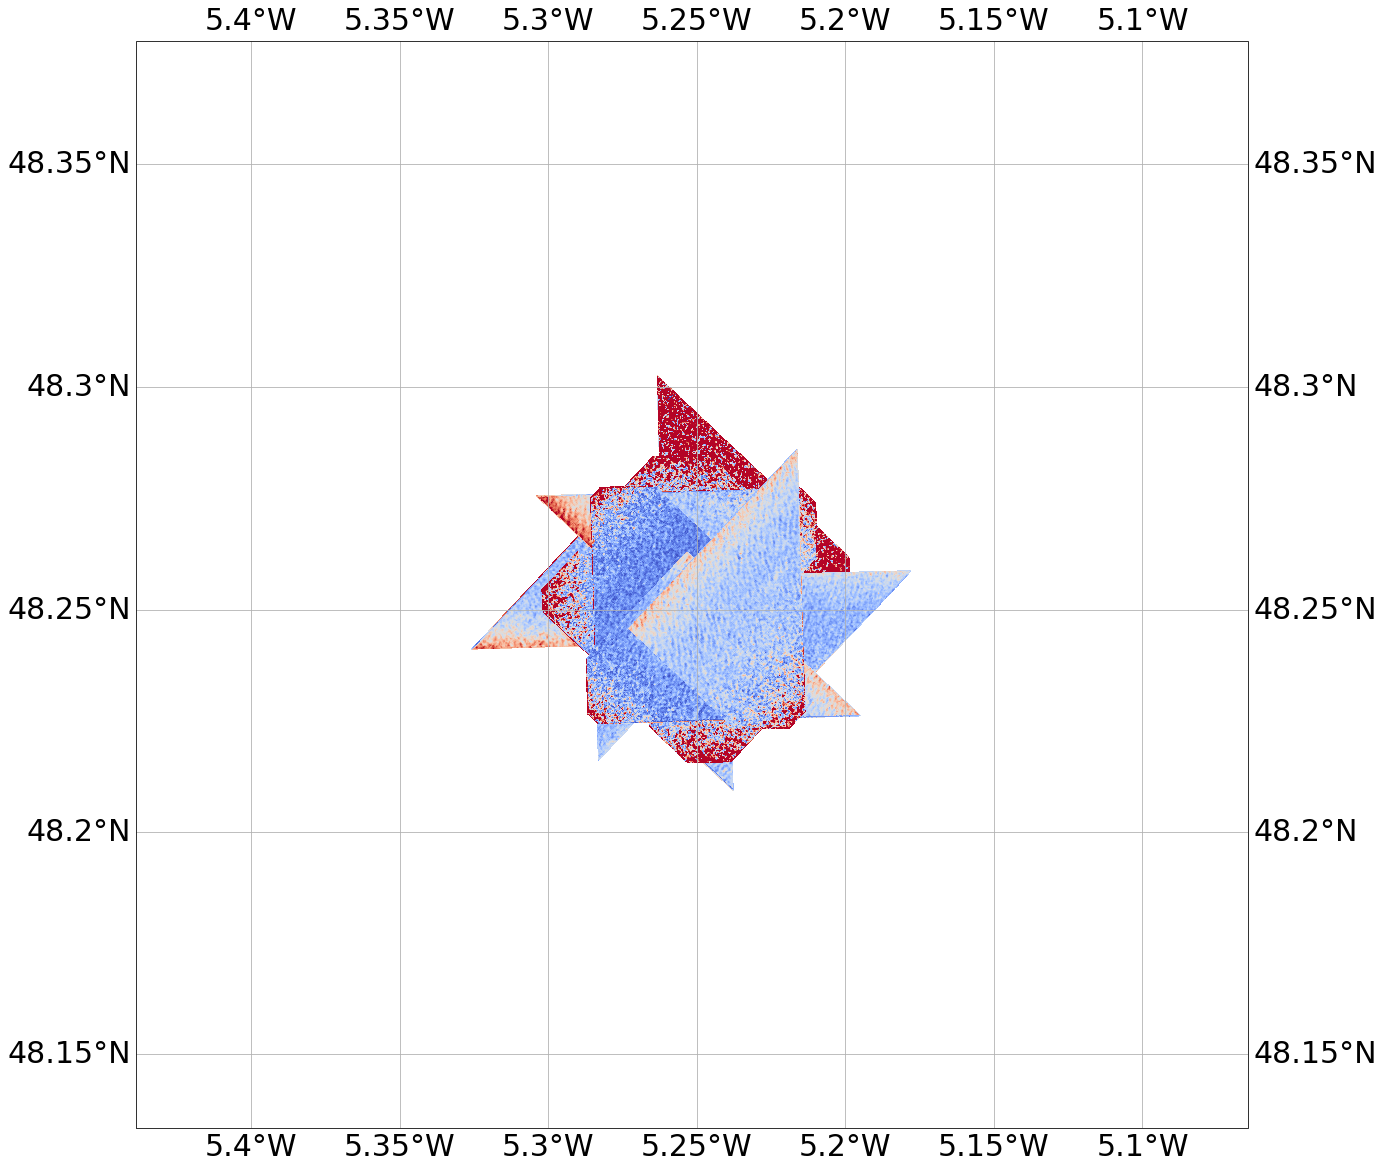

In [6]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
for track in ds_l2_star.keys():
    img=ds_l2_star[track].CurrentMagnitude
    img_masked = np.ma.masked_where(img != 0, img)
    img.where(img_masked).plot(
        y='latitude', x='longitude',
        robust=True,
        cmap='coolwarm',
        vmin=0, vmax=2,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )

gl=ax.gridlines(draw_labels=True)
gl.xlabel_style = {'size': 30, 'color': 'black'}
gl.ylabel_style = {'size': 30, 'color': 'black'}
#ax.set_extent([-5.17, -5.1, 48.37, 48.5], crs=ccrs.PlateCarree()) plt.show()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(40)

In [21]:
ds_l1_star['Track_12']

<xarray.Dataset>
Dimensions:                                 (Antenna: 3, CrossRange: 2565, GroundRange: 742, GPSTime: 1315104, AntPatternAngles: 201, ModelTransformationTagCols: 4, ModelTransformationTagRows: 4, GBPGridInfo: 9)
Coordinates:
  * Antenna                                 (Antenna) <U4 'Mid' 'Fore' 'Aft'
  * CrossRange                              (CrossRange) float64 -1.22e+04 .....
  * GroundRange                             (GroundRange) float64 1.616e+03 ....
  * GPSTime                                 (GPSTime) float64 2.318e+04 ... 2...
  * AntPatternAngles                        (AntPatternAngles) float64 -90.0 ...
  * GBPGridInfo                             (GBPGridInfo) float64 3.326e+05 ....
    latitude                                (CrossRange, GroundRange) float64 ...
    longitude                               (CrossRange, GroundRange) float64 ...
Dimensions without coordinates: ModelTransformationTagCols, ModelTransformationTagRows
Data variables: (12/108)
    SigmaImageSingleLookRealPart            (Antenna, CrossRange, GroundRange) float64 ...
    SigmaImageSingleLookImaginaryPart       (Antenna, CrossRange, GroundRange) float64 ...
    LatImage                                (Antenna, CrossRange, GroundRange) float64 ...
    LonImage                                (Antenna, CrossRange, GroundRange) float64 ...
    DEMImage                                (Antenna, CrossRange, GroundRange) float32 ...
    OrbLatImage                             (Antenna, CrossRange, GroundRange) float64 ...
    ...                                      ...
    Baseline                                (Antenna) float64 0.2 0.2 0.2
    AntennaAzimuthImage                     (Antenna, CrossRange, GroundRange) float64 ...
    TimeLag                                 (Antenna, CrossRange, GroundRange) float64 ...
    CentralWavenumber                       (Antenna) float64 282.9 282.9 282.9
    RadialSurfaceVelocity                   (Antenna, CrossRange, GroundRange) float64 ...
    RadialSurfaceCurrent                    (Antenna, CrossRange, GroundRange) float64 ...
Attributes:
    Title:     Track : 20220522T062620
    Source:    MetaSensing Airborne SAR
    History:   04-Nov-2022 11:18:47 File Generation
    Comments:  /media/Y/BREST_PROJECT/20220522T062620

In [53]:
fig = plt.figure(figsize=(10, 10))

for track in ds_l2_star.keys():
    ds_l1_star[track].set_coords('AntennaAzimuthImage')
    ds_l1_star[track].sel(Antenna='Aft')\
    .mean()\
    .plot.scatter(y='RadialSurfaceVelocity',x='AntennaAzimuthImage',
          label=track)
plt.ylim([-1.5, 1.5])
plt.legend()

C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: x must be one of (OrbitLatitude, UTMZone, OrbitHeight, IntensityAvgMaster, FinalYear, RxAzimuthGainSlave, MaxProcessedDoppler, SystemType, OrbitHeading, RxPolarization, IntensityAvgComplexMasterSlave, RxPointAz, FinalHourSlave, StartMonthSlave, SigmaImageSingleLookRealPartSlave, Longitude11, TxElevationGainSlave, RadialSurfaceCurrent, TxPolarization, StartDaySlave, StartMonth, Coherence, StartSec, OrbitLongitude, FinalSecSlave, StartYear, FinalDay, OrbLonImageSlave, OrbLatImage, Antenna, FinalDaySlave, SigmaImageSingleLookImaginaryPartSlave, StartMin, StartSecSlave, StartDay, DEMImage, RxElevationGain, CalImage, OrbLonImage, CentralWavenumber, LookAngleImage, StartMinSlave, RxPointEl, TxAzimuthGain, IntensityAvgSlave, OrbitRoll, Intensity, TxAzimuthGainSlave, LonImage, FinalMonthSlave, TxElevationGain, ModelTransformationTag, OrbitHeadingImage, CalImageSlave, OrbitYawImage, TransmittedBandWidth, TxPolarizationSlave, PRF, OrbTimeImage, MinProcessedDoppler, RxPolarizationSlave, CentralFreq, OrbHeightImage, Hemisphere, Longitude12, Polarization, Latitude11, Interferogram, SigmaImageSingleLookRealPart, SigmaImageSingleLookImaginaryPart, Latitude22, StartHourSlave, RadialSurfaceVelocity, SigmaSLCMaster, StartHour, Latitude12, LatImage, SystemTypeSlave, FinalMinSlave, WindowFunction, MeanForwardVelocity, OrbLatImageSlave, LookDirection, FinalYearSlave, FinalMin, OrbTimeImageSlave, Dummy, OrbitPitch, TxPointAz, SquintImage, Longitude21, FinalSec, Latitude21, IncidenceAngleImage, OrbitImage, OrbitImageSlave, RxElevationGainSlave, SigmaSLCSlave, TimeLag, FinalHour, OrbHeightImageSlave, RxAzimuthGain, Baseline, FinalMonth, StartYearSlave, TxPointEl, Longitude22, DopplerPresumming)

<Figure size 720x720 with 0 Axes>

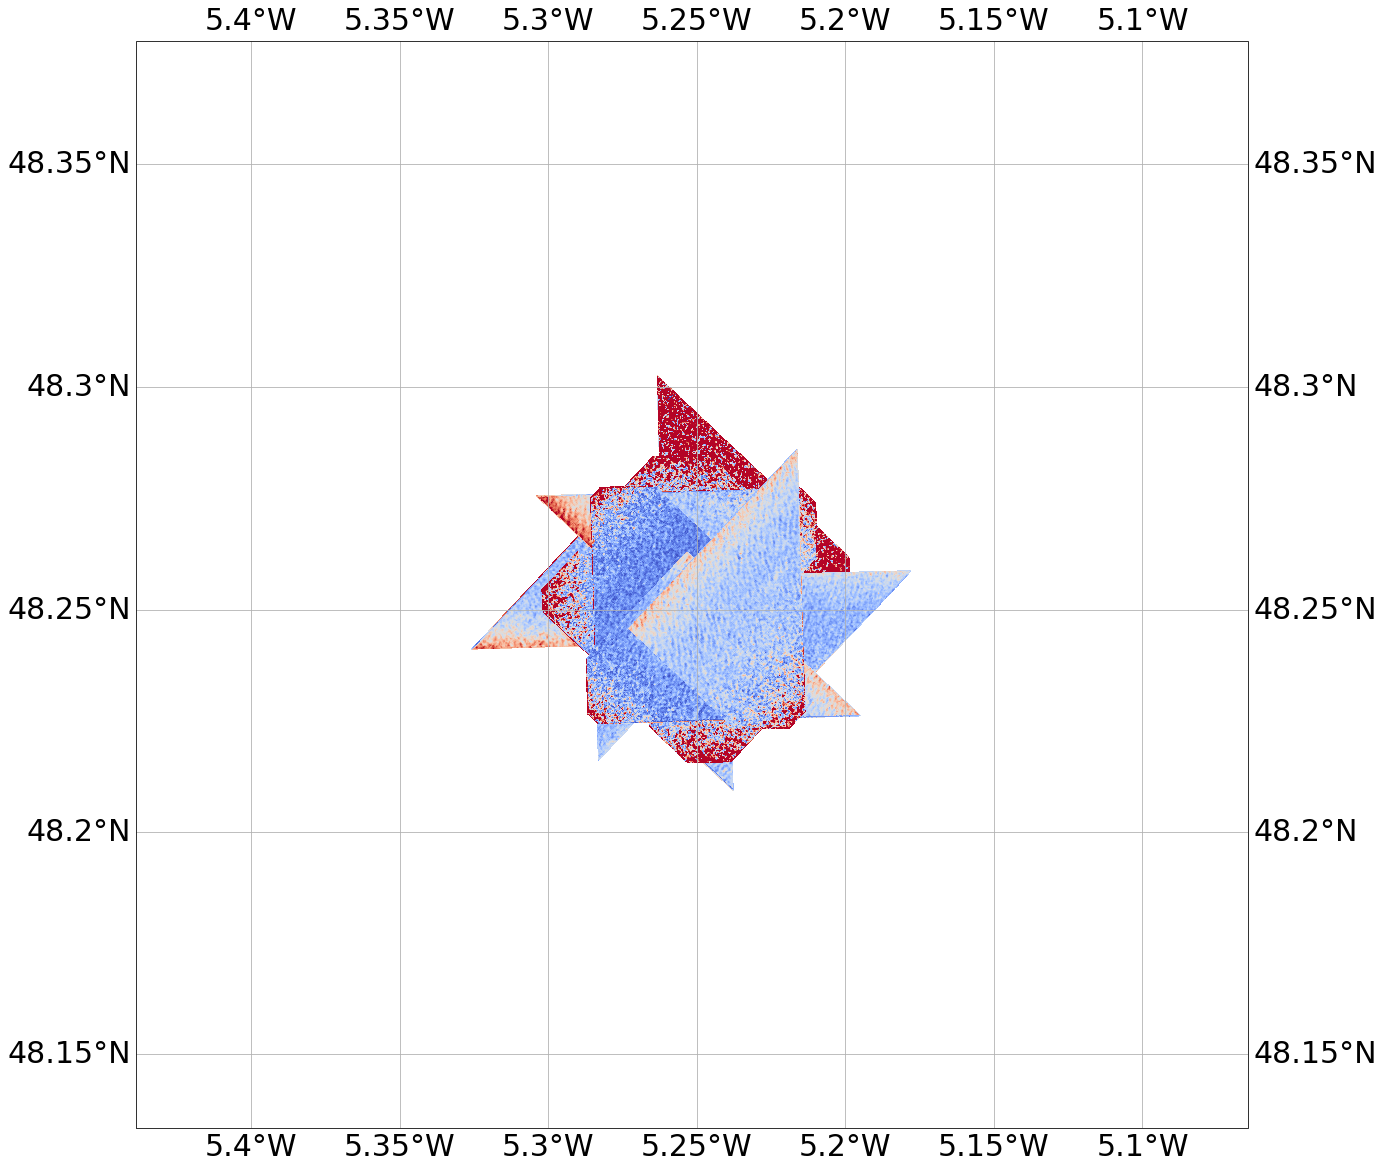

In [6]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
for track in ds_l2_star.keys():
    img=ds_l2_star[track].CurrentMagnitude
    img_masked = np.ma.masked_where(img != 0, img)
    img.where(img_masked).plot(
        y='latitude', x='longitude',
        robust=True,
        cmap='coolwarm',
        vmin=0, vmax=2,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )

gl=ax.gridlines(draw_labels=True)
gl.xlabel_style = {'size': 30, 'color': 'black'}
gl.ylabel_style = {'size': 30, 'color': 'black'}
#ax.set_extent([-5.17, -5.1, 48.37, 48.5], crs=ccrs.PlateCarree()) plt.show()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(40)

In [38]:
coords_list=['TxPolarization',
 'RxPolarization',                        
'LookDirection',                          
'SystemType',                             
'TxPolarizationSlave',                     
'RxPolarizationSlave',                    
'SystemTypeSlave',                  
'Polarization',]                            

In [51]:
ds_l1_star[track].data_vars

Data variables:
    SigmaImageSingleLookRealPart            (Antenna, CrossRange, GroundRange) float64 ...
    SigmaImageSingleLookImaginaryPart       (Antenna, CrossRange, GroundRange) float64 ...
    LatImage                                (Antenna, CrossRange, GroundRange) float64 ...
    LonImage                                (Antenna, CrossRange, GroundRange) float64 ...
    DEMImage                                (Antenna, CrossRange, GroundRange) float32 ...
    OrbLatImage                             (Antenna, CrossRange, GroundRange) float64 ...
    OrbLonImage                             (Antenna, CrossRange, GroundRange) float64 ...
    OrbHeightImage                          (Antenna, CrossRange, GroundRange) float64 ...
    OrbTimeImage                            (Antenna, CrossRange, GroundRange) float64 ...
    CalImage                                (Antenna, CrossRange, GroundRange) float32 ...
    OrbitImage                              (Antenna, CrossRange, GroundRa

In [54]:
ds_l1_star[track]

<xarray.Dataset>
Dimensions:                                 (Antenna: 3, CrossRange: 2566, GroundRange: 741, GPSTime: 1488144, AntPatternAngles: 201, ModelTransformationTagCols: 4, ModelTransformationTagRows: 4, GBPGridInfo: 9)
Coordinates: (12/17)
  * Antenna                                 (Antenna) <U4 'Mid' 'Fore' 'Aft'
  * CrossRange                              (CrossRange) float64 -1.225e+04 ....
  * GroundRange                             (GroundRange) float64 1.616e+03 ....
  * GPSTime                                 (GPSTime) float64 2.282e+04 ... 2...
  * AntPatternAngles                        (AntPatternAngles) float64 -90.0 ...
  * GBPGridInfo                             (GBPGridInfo) float64 3.305e+05 ....
    ...                                      ...
    RxPolarizationSlave                     (Antenna) |S1 b'V' b'V' b'V'
    SystemTypeSlave                         (Antenna) |S1 b'M' b'M' b'M'
    Polarization                            (Antenna) <U2 'VV' 'VV' 'VV'
    AntennaAzimuthImage                     (Antenna, CrossRange, GroundRange) float64 ...
    latitude                                (CrossRange, GroundRange) float64 ...
    longitude                               (CrossRange, GroundRange) float64 ...
Dimensions without coordinates: ModelTransformationTagCols, ModelTransformationTagRows
Data variables: (12/99)
    SigmaImageSingleLookRealPart            (Antenna, CrossRange, GroundRange) float64 ...
    SigmaImageSingleLookImaginaryPart       (Antenna, CrossRange, GroundRange) float64 ...
    LatImage                                (Antenna, CrossRange, GroundRange) float64 ...
    LonImage                                (Antenna, CrossRange, GroundRange) float64 ...
    DEMImage                                (Antenna, CrossRange, GroundRange) float32 ...
    OrbLatImage                             (Antenna, CrossRange, GroundRange) float64 ...
    ...                                      ...
    Coherence                               (Antenna, CrossRange, GroundRange) float64 ...
    Baseline                                (Antenna) float64 0.2 0.2 0.2
    TimeLag                                 (Antenna, CrossRange, GroundRange) float64 ...
    CentralWavenumber                       (Antenna) float64 282.9 282.9 282.9
    RadialSurfaceVelocity                   (Antenna, CrossRange, GroundRange) float64 ...
    RadialSurfaceCurrent                    (Antenna, CrossRange, GroundRange) float64 ...
Attributes:
    Title:     Track : 20220522T062018
    Source:    MetaSensing Airborne SAR
    History:   04-Nov-2022 11:12:32 File Generation
    Comments:  /media/Y/BREST_PROJECT/20220522T062018

In [52]:
fig = plt.figure(figsize=(10, 10))

for track in ds_l2_star.keys():
    ds_l1_star[track] = ds_l1_star[track].set_coords('AntennaAzimuthImage')
    ds_l1_star[track] = ds_l1_star[track].set_coords(coords_list)
    ds_l1_star[track].sel(Antenna='Aft')\
    .mean()\
    .plot()


C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\d

<Figure size 720x720 with 0 Axes>

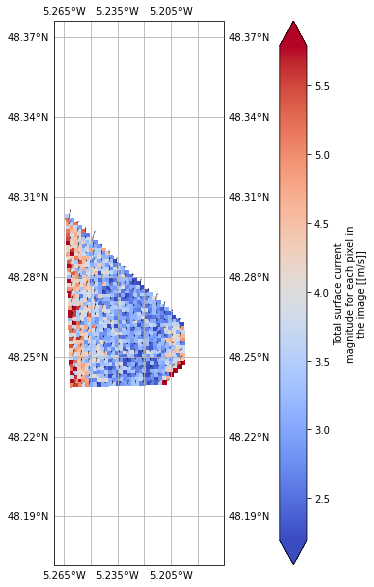

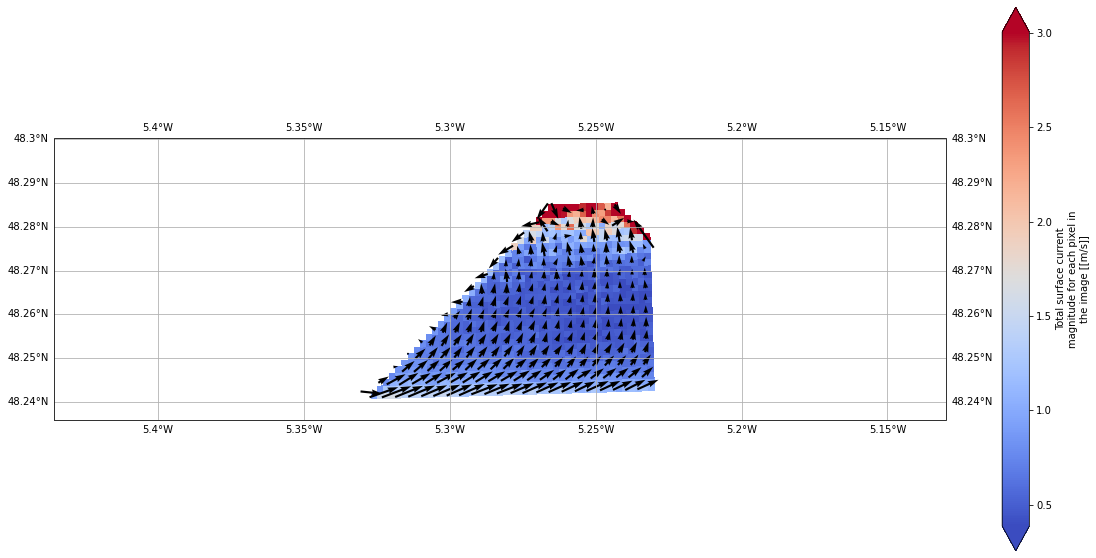

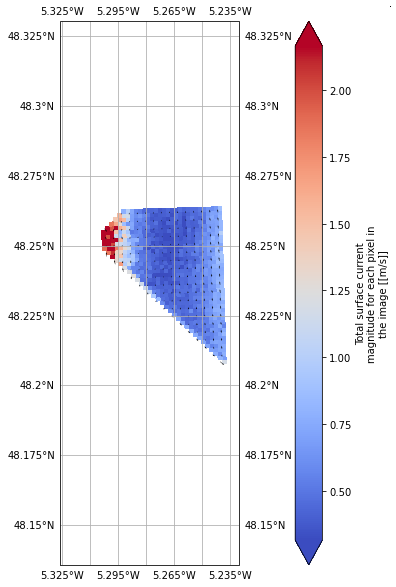

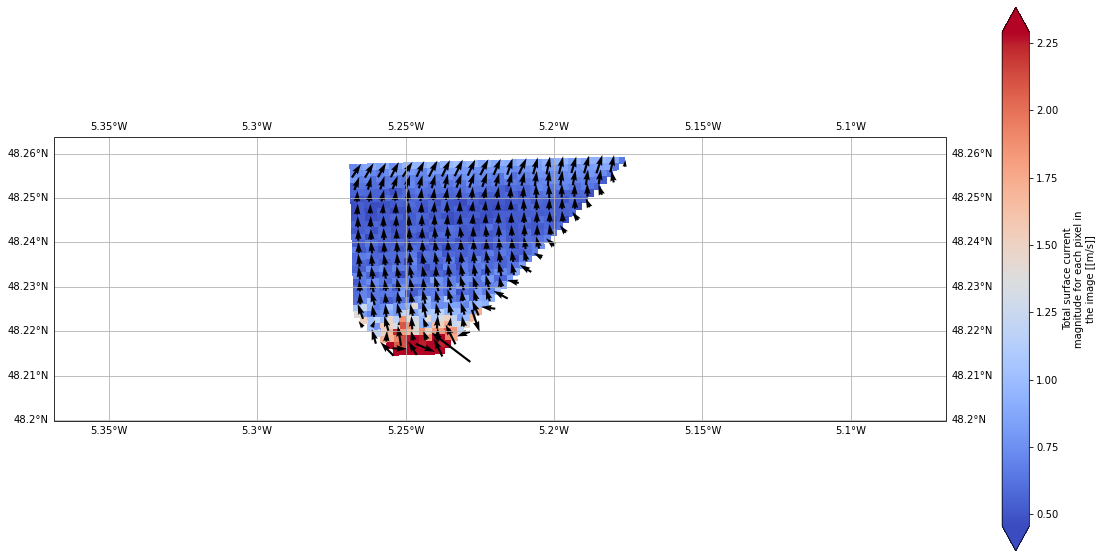

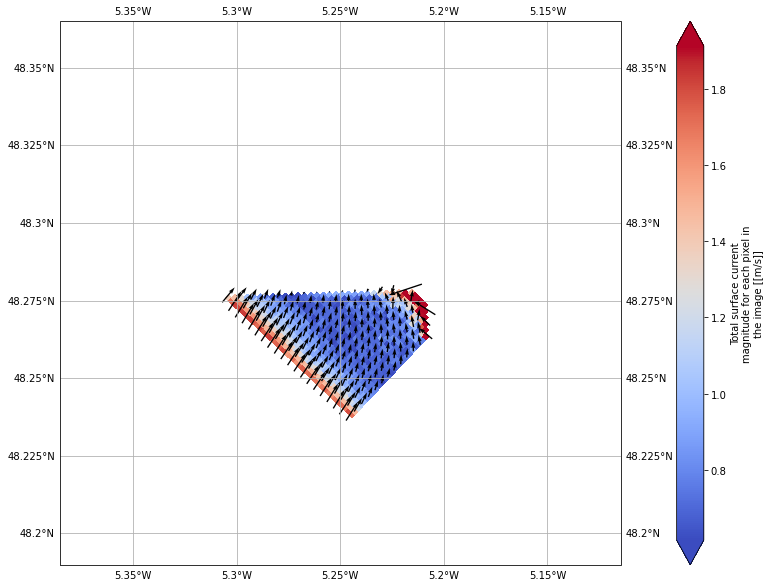

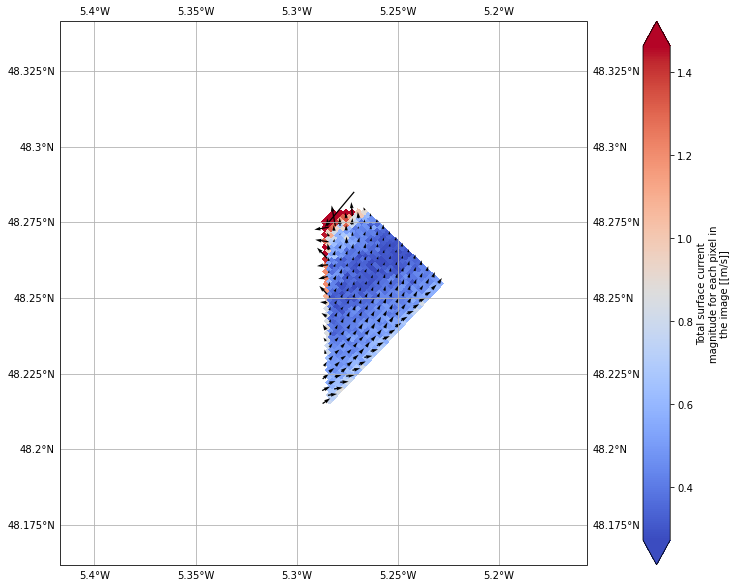

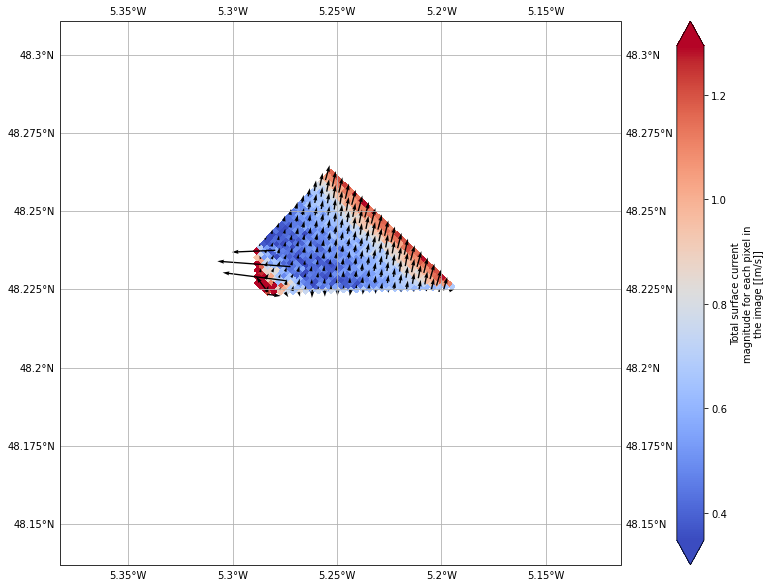

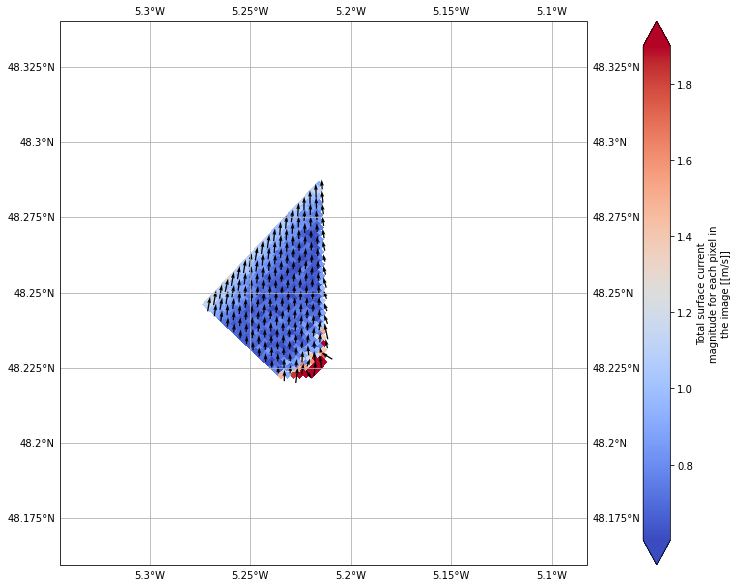

In [8]:
c_factor = 20
q_factor = 40
for track in ds_l2_star.keys():
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())


    ds_l2_star[track]\
    .coarsen(GroundRange=c_factor,boundary='trim').mean()\
    .coarsen(CrossRange=c_factor,boundary='trim').mean()\
    .CurrentMagnitude.plot(
        y='latitude',
        x='longitude',
        robust=True, 
        cmap='coolwarm',
        #vmin=0, #vmax=2.5,
        transform=ccrs.PlateCarree()
    )
    ds_l2_star[track]\
    .coarsen(GroundRange=q_factor,boundary='trim').mean()\
    .coarsen(CrossRange=q_factor,boundary='trim').mean()\
    .plot.quiver(
        x='longitude',
        y='latitude',
        u='CurrentVectorUComponent',
        v='CurrentVectorVComponent',
        scale=40,
        angles='xy',
        robust=True,
        transform=ccrs.PlateCarree()
    )
    gl=ax.gridlines(draw_labels=True)
    #ax.set_extent([-5.17, -5.1, 48.37, 48.5], crs=ccrs.PlateCarree())
    plt.show()

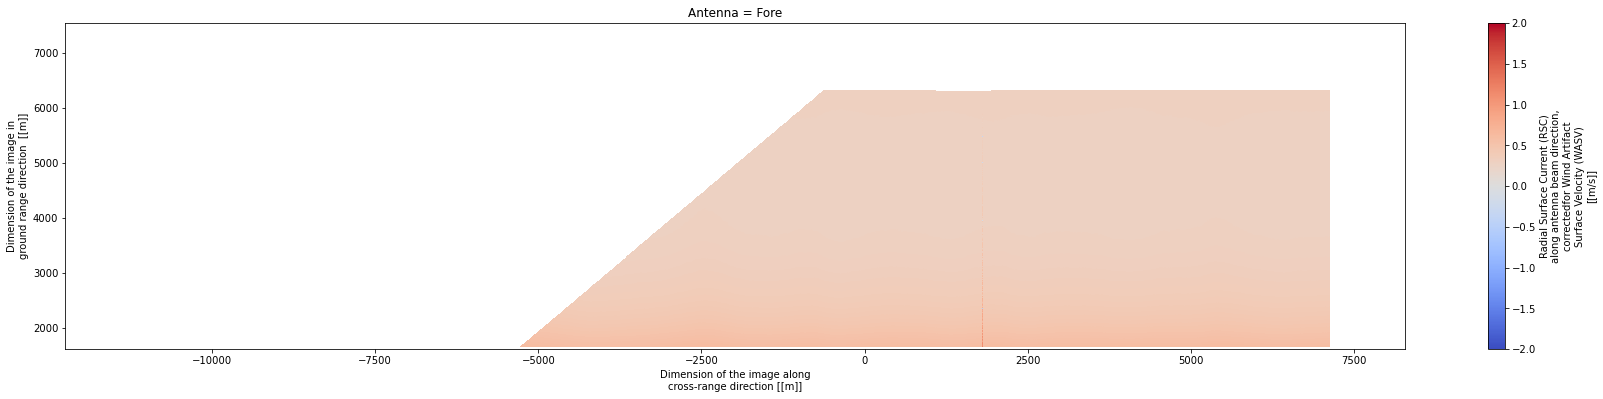

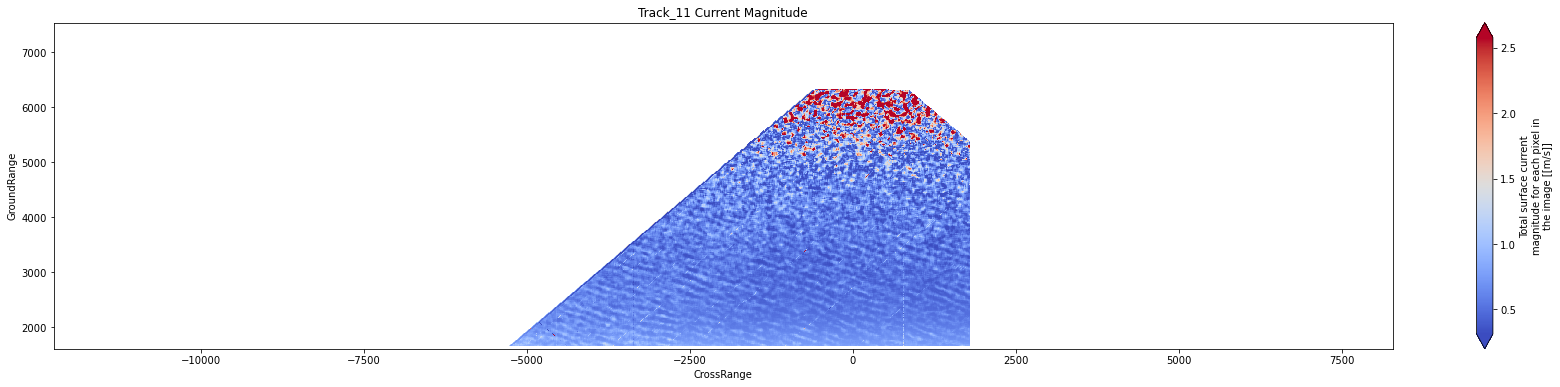

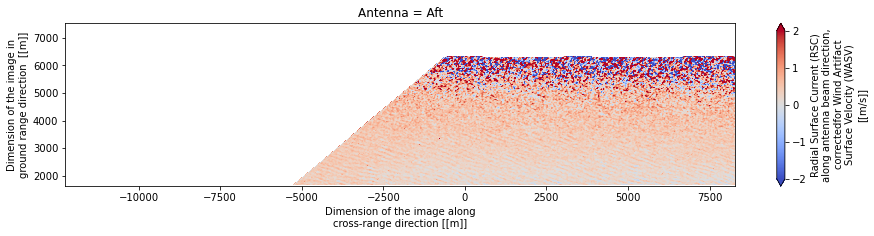

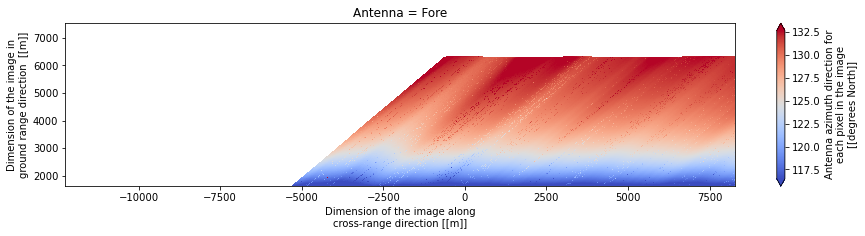

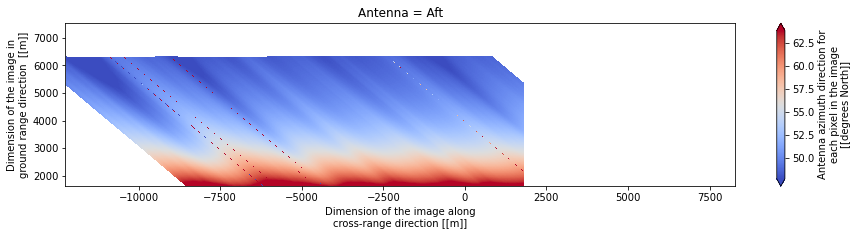

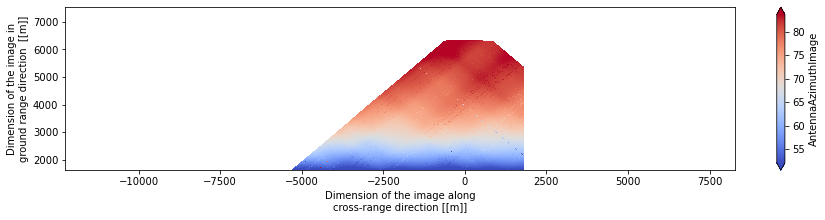

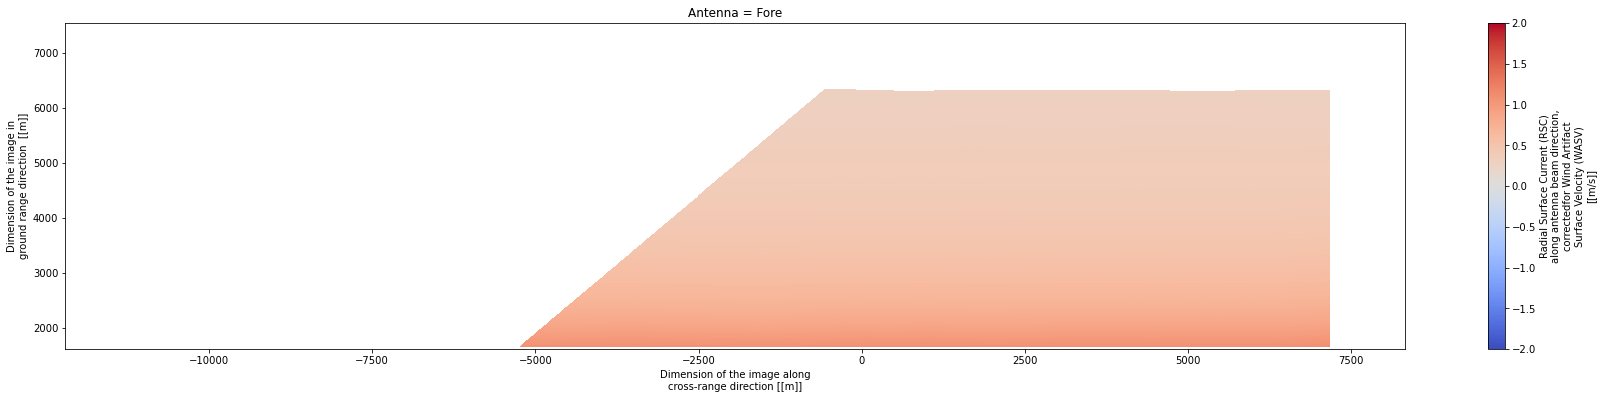

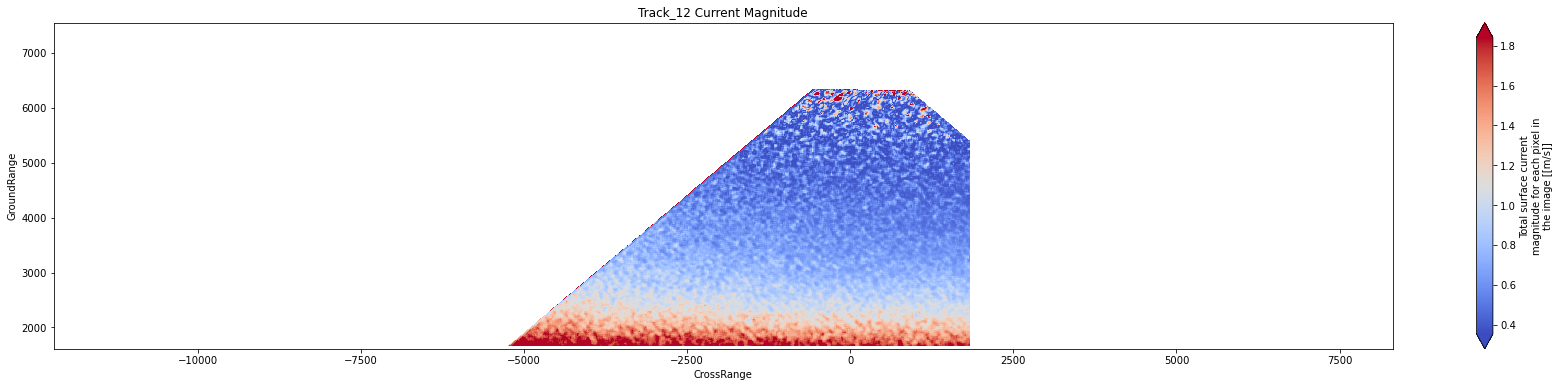

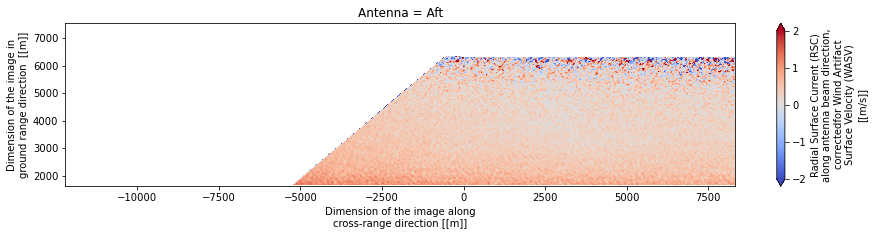

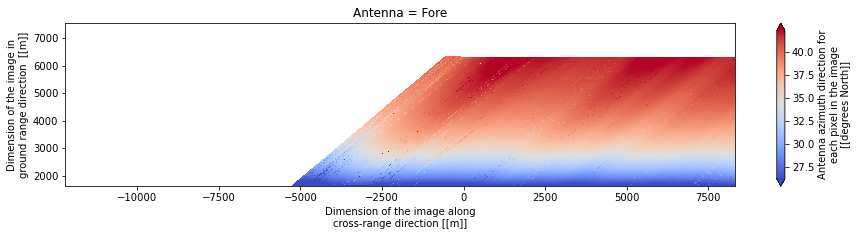

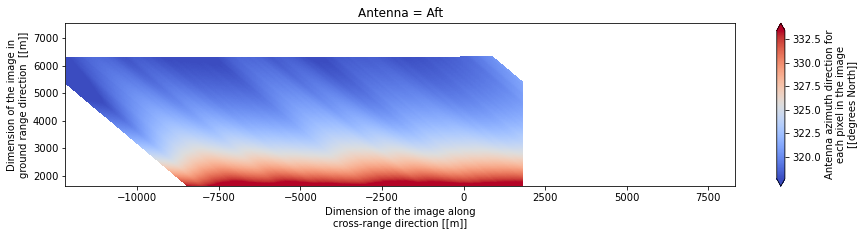

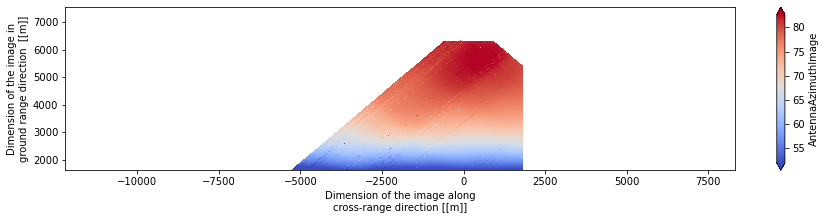

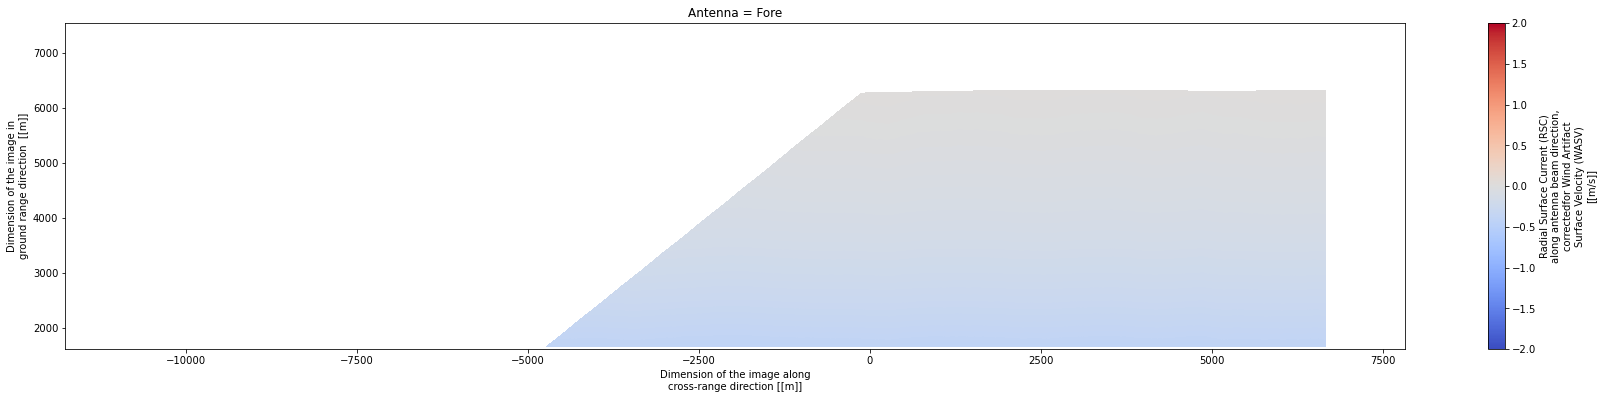

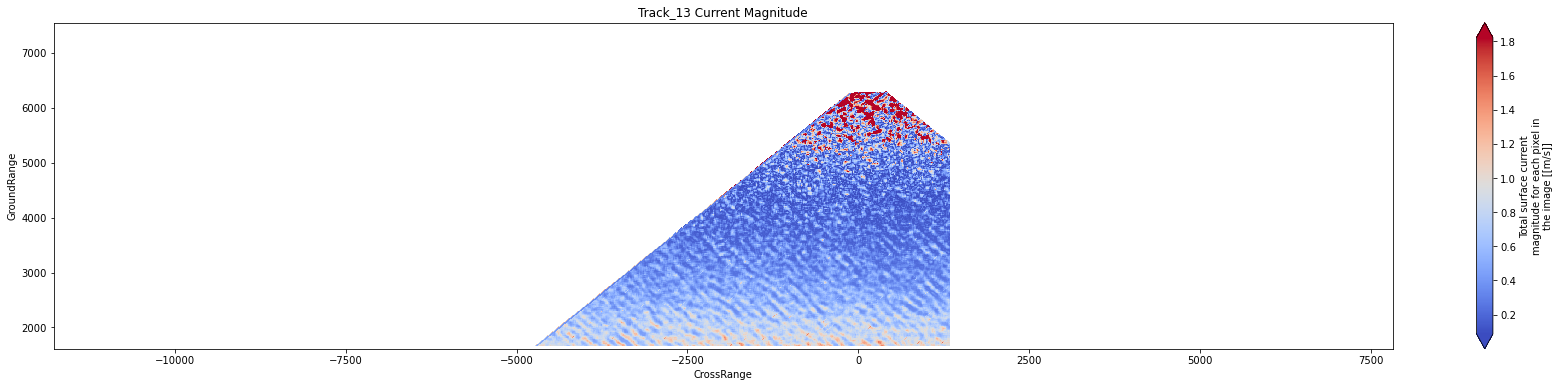

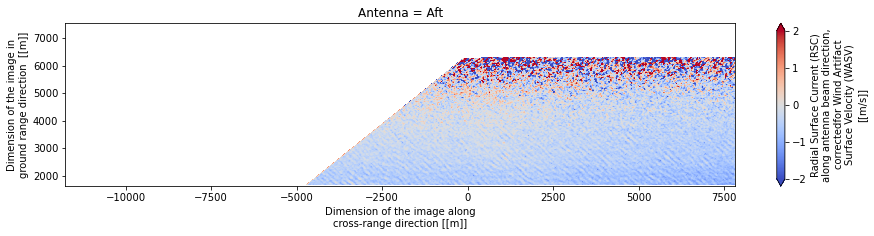

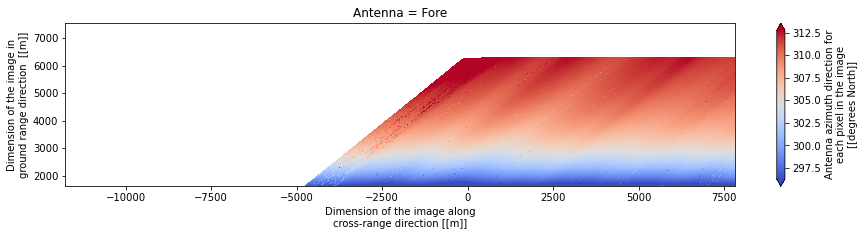

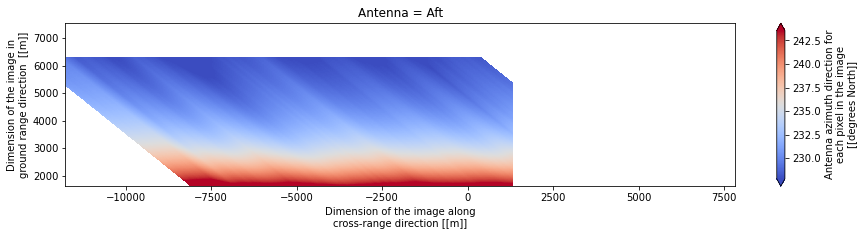

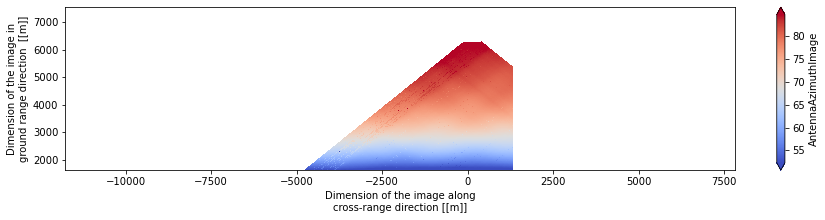

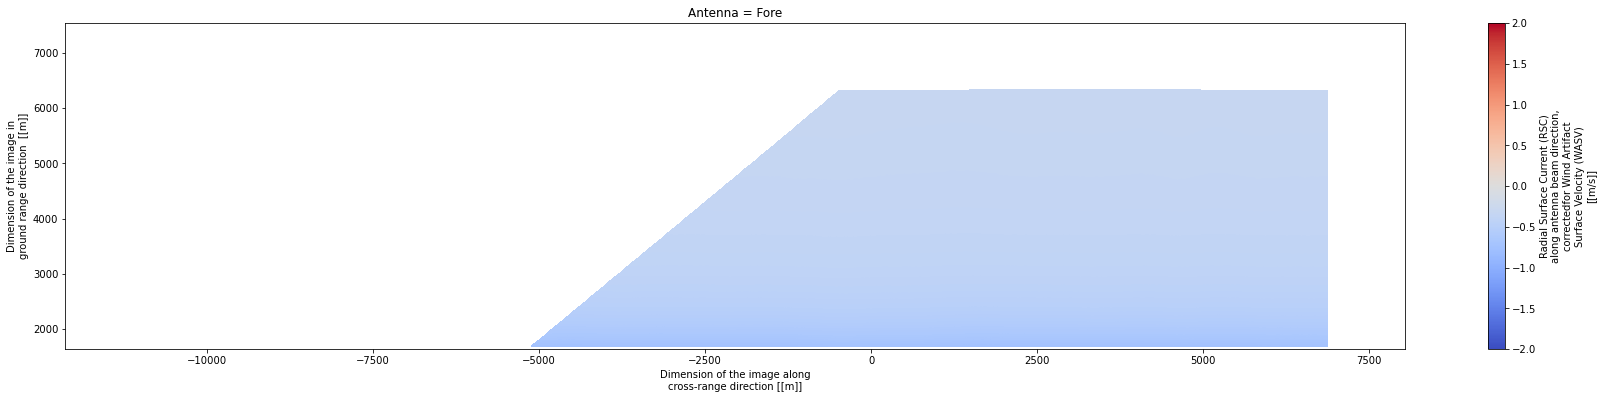

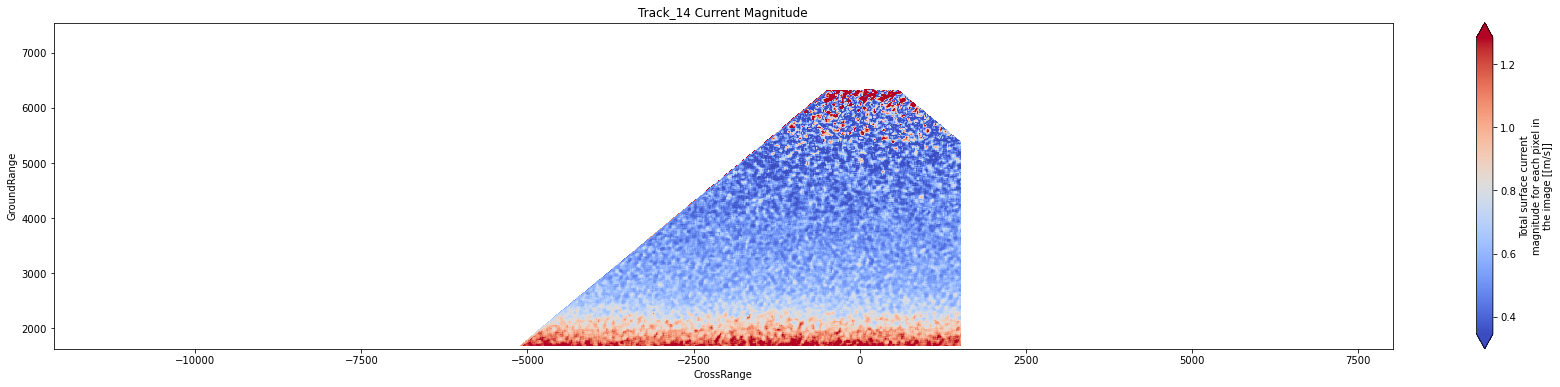

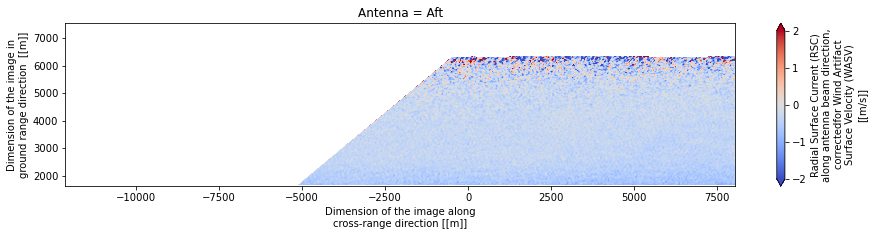

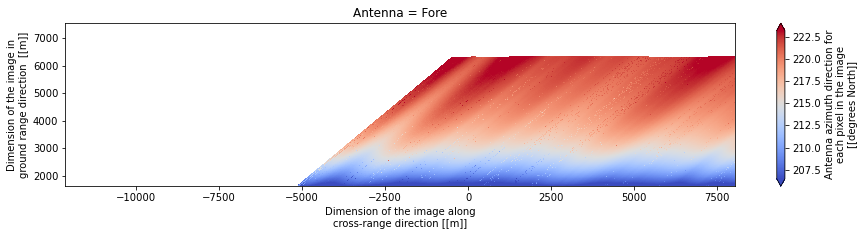

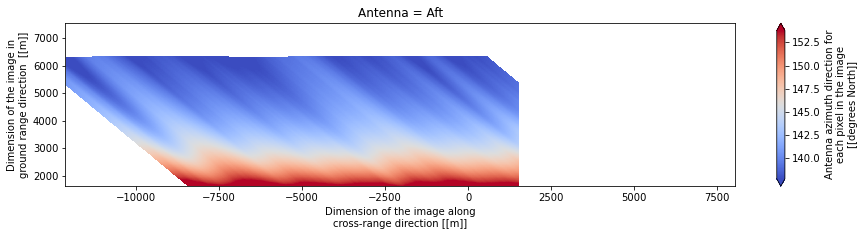

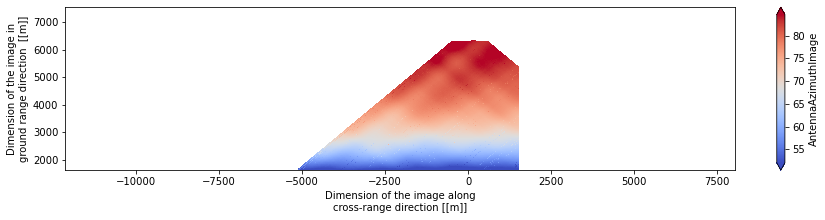

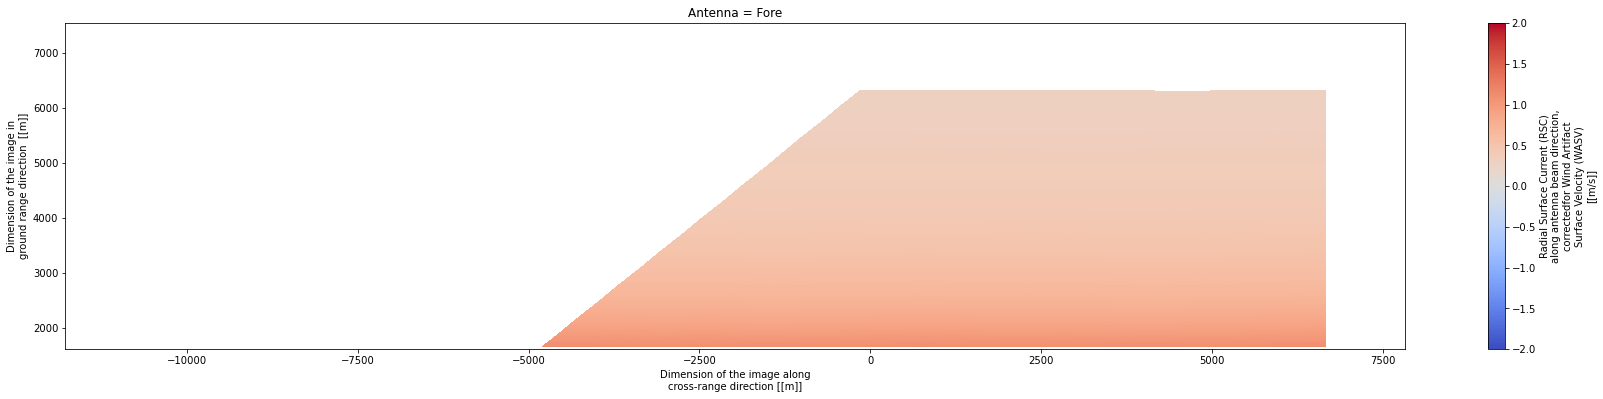

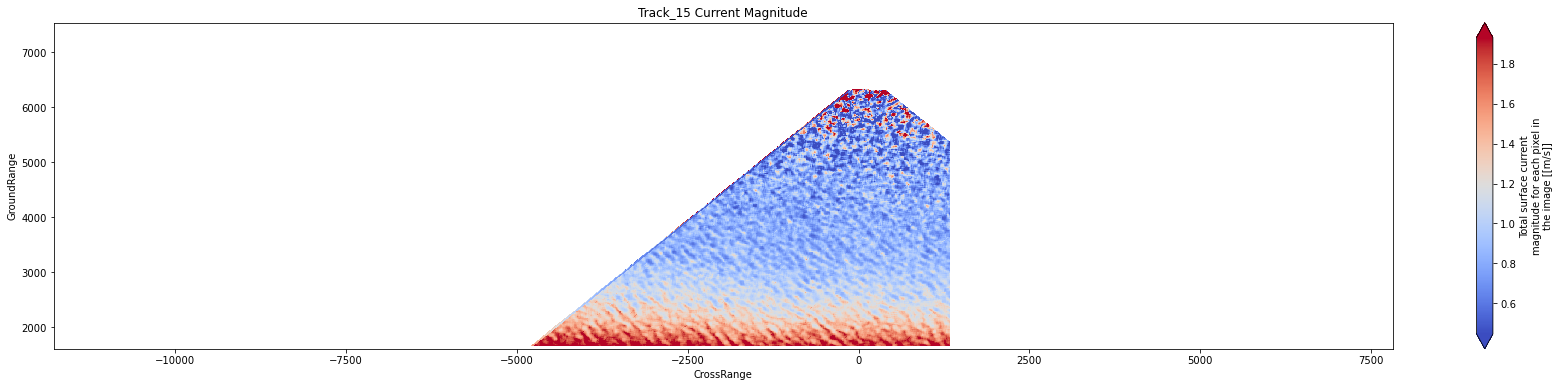

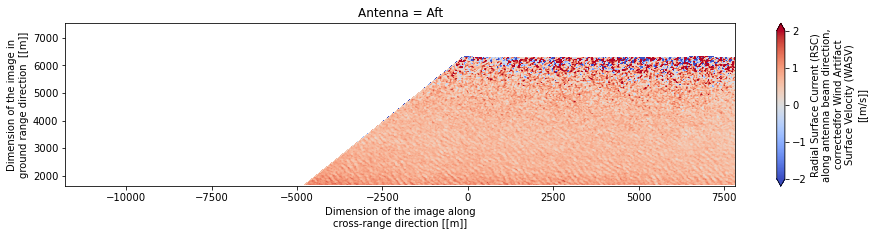

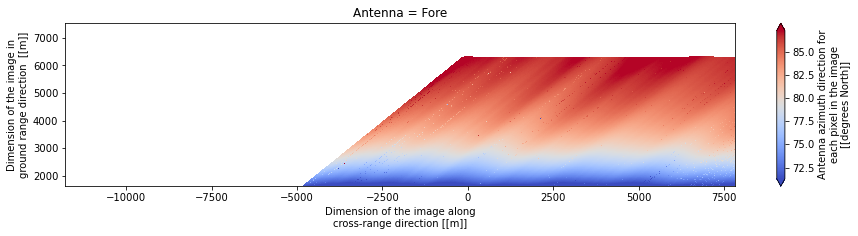

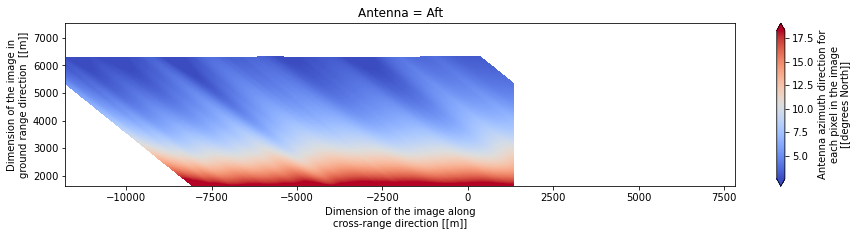

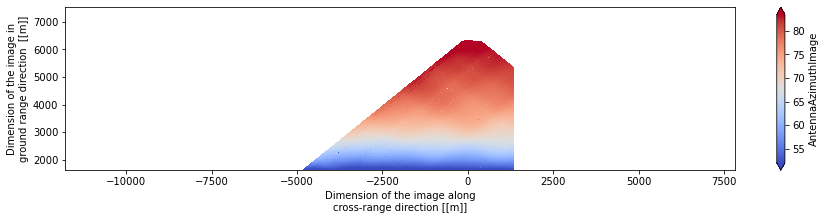

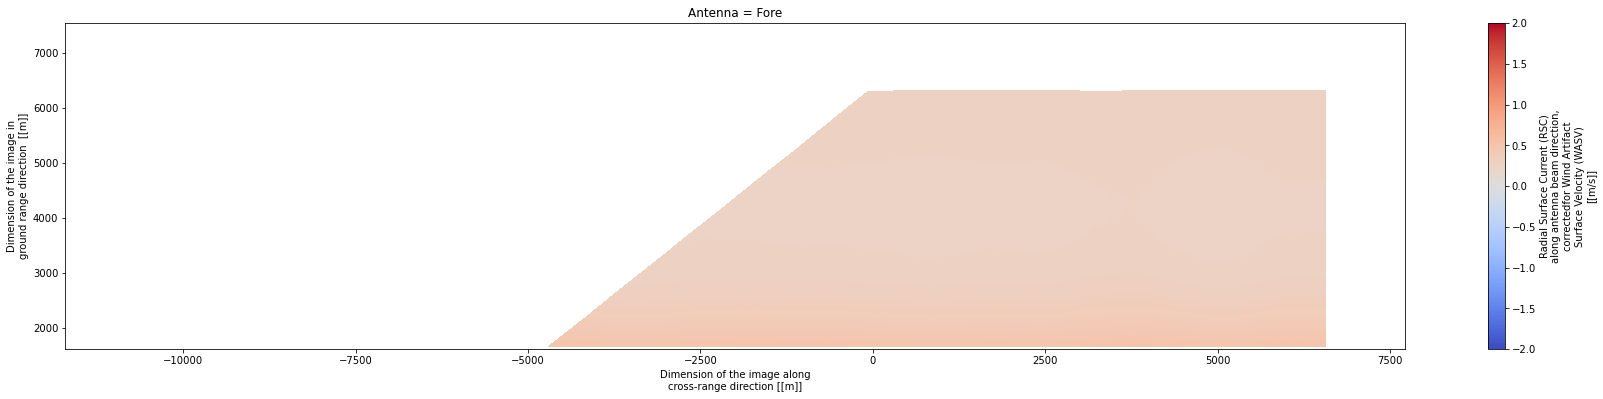

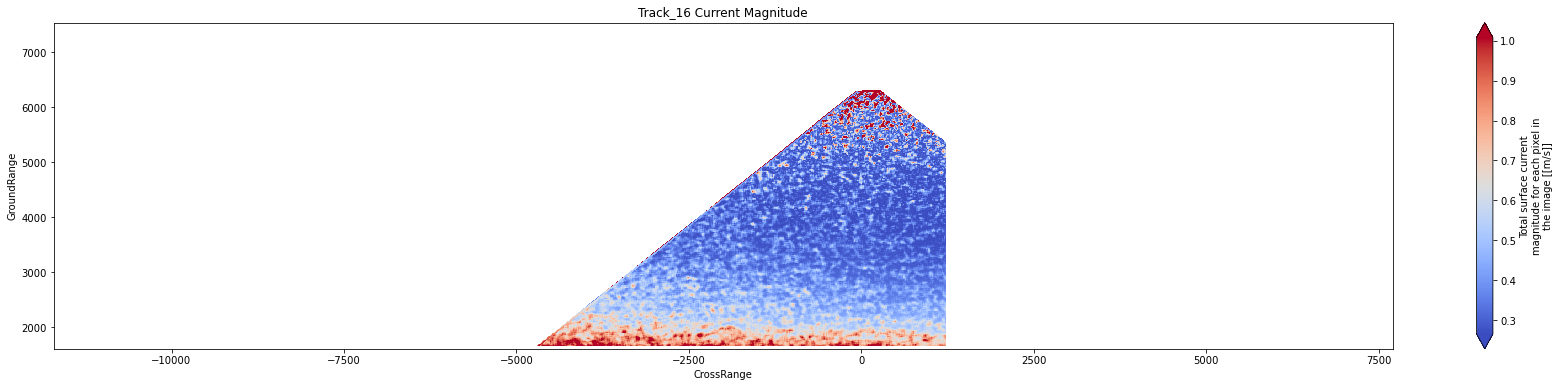

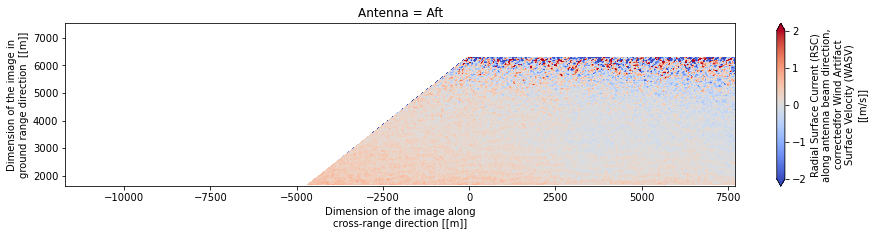

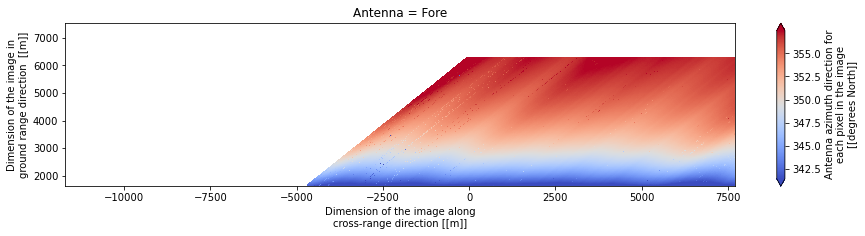

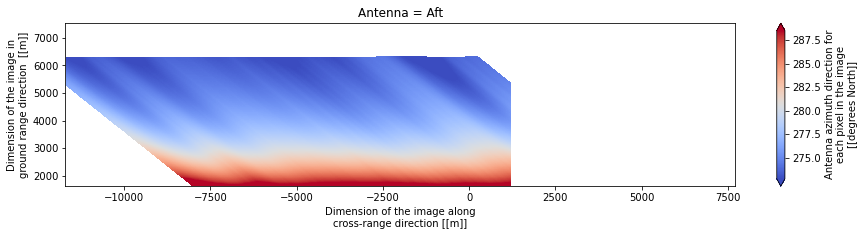

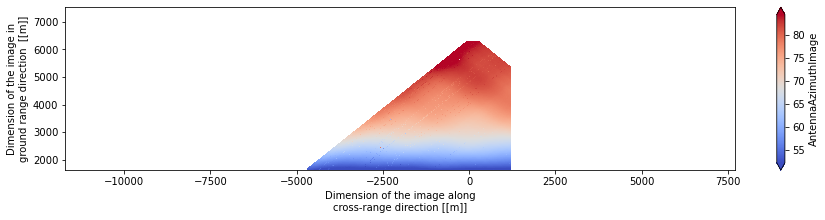

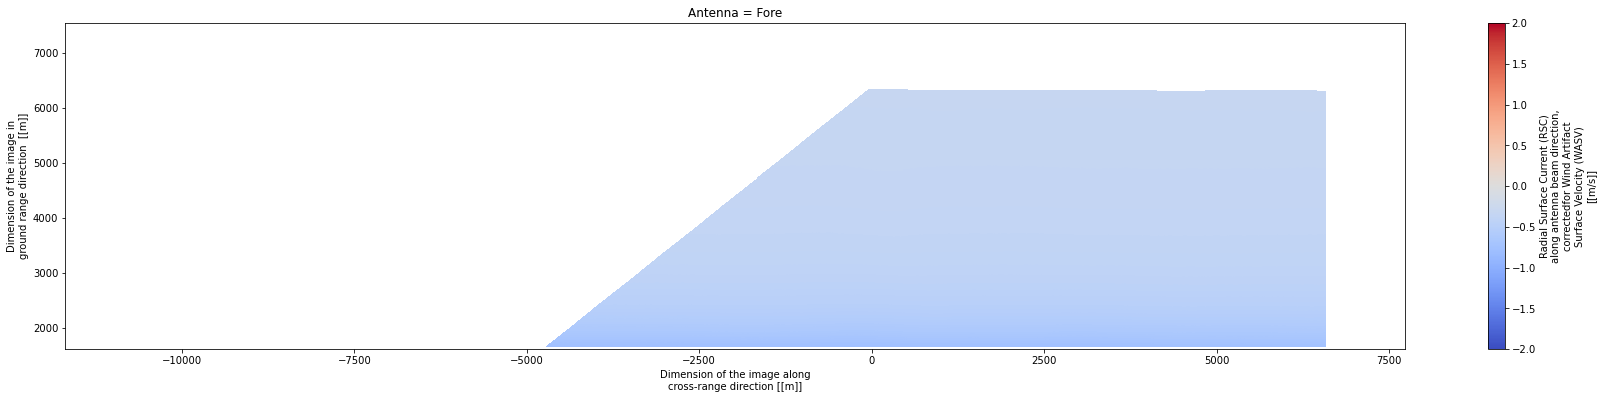

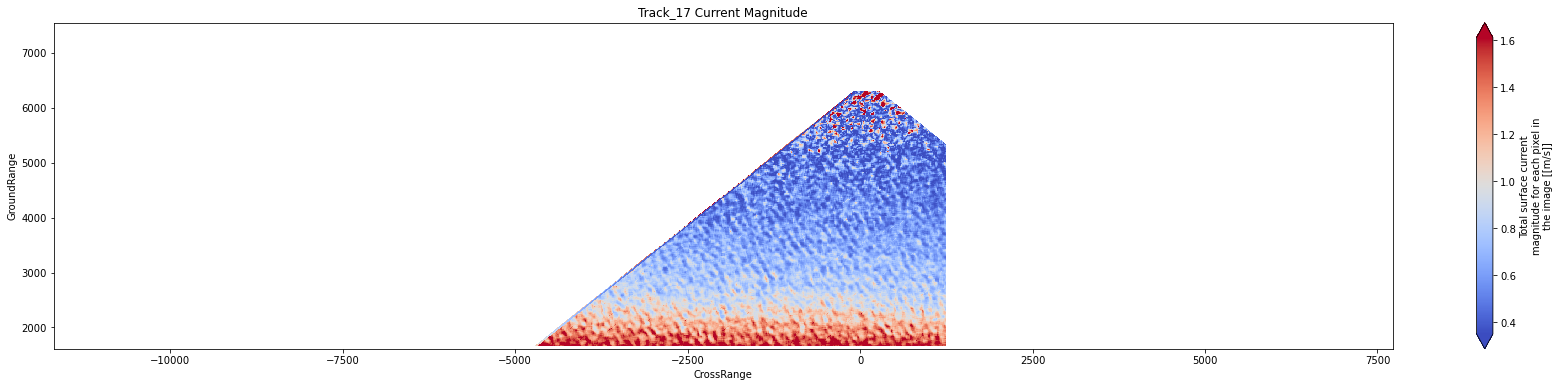

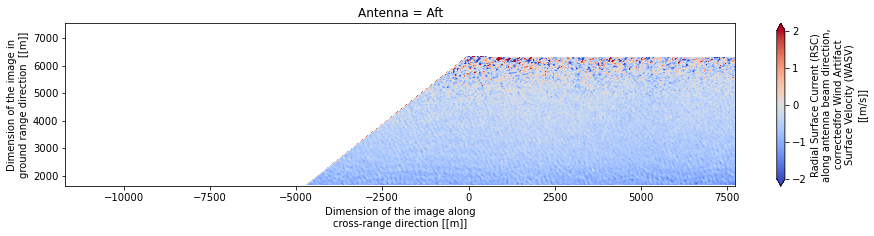

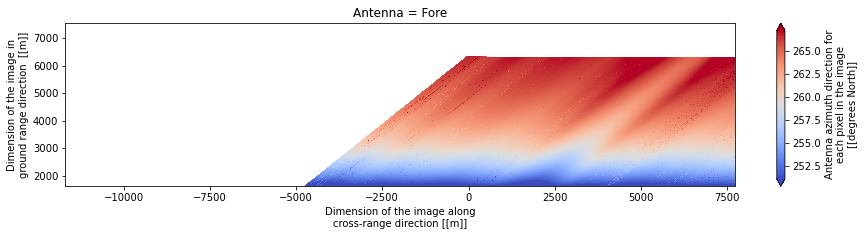

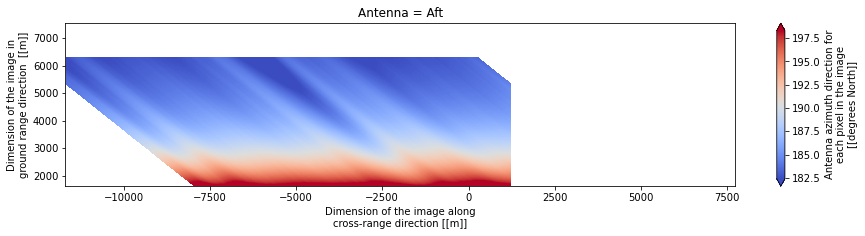

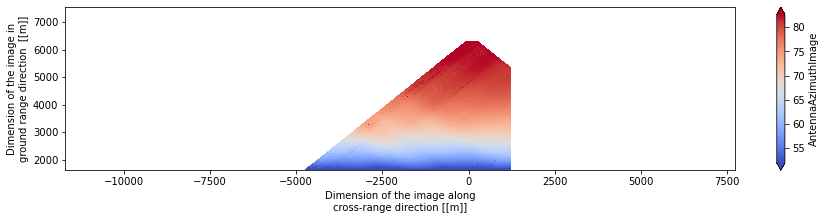

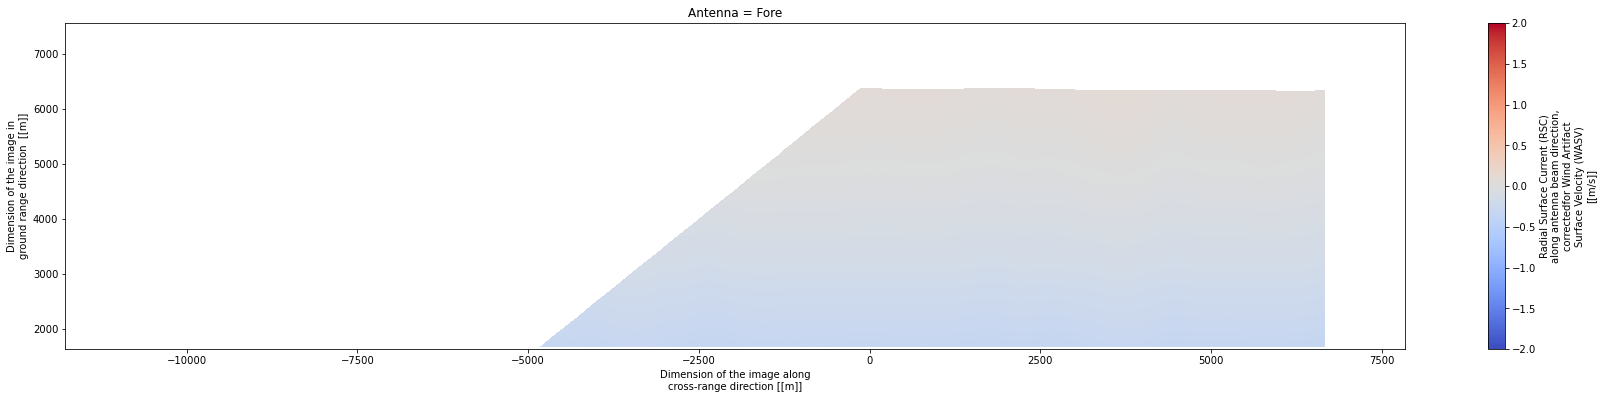

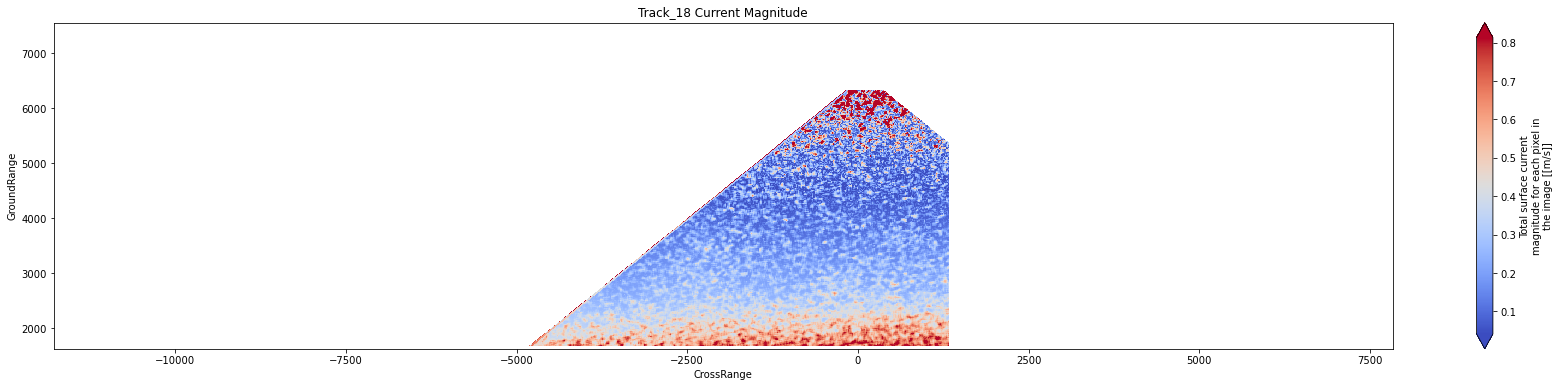

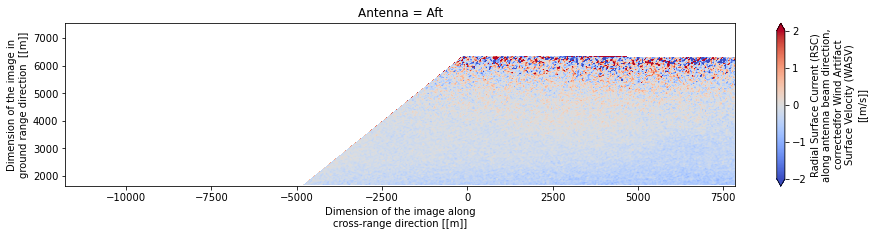

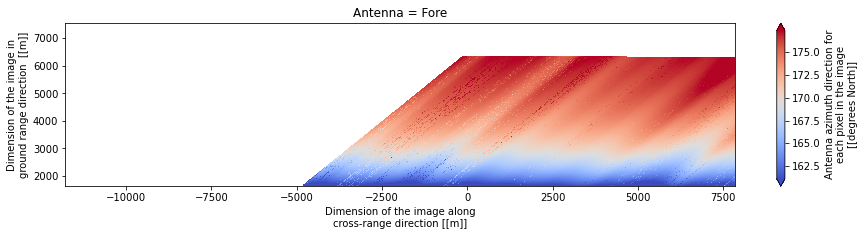

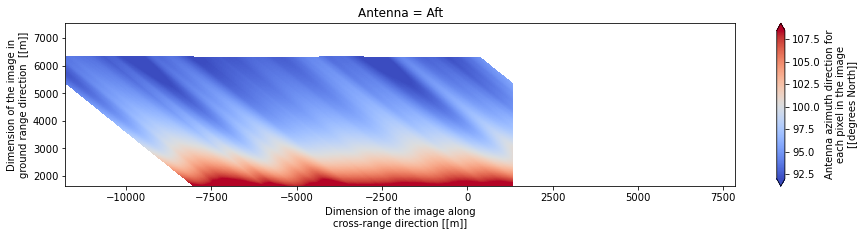

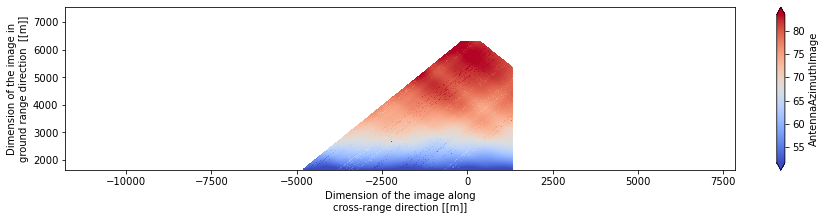

In [16]:
# Plot L1 RSC and L2 Current Magnitude in SAR local coordinates

for track in ds_l2_star.keys():

    ax = ds_l1_star[track].RadialSurfaceCurrent.sel(Antenna='Fore').plot(
    figsize=(30, 6),
    y='GroundRange',
    x='CrossRange',
    robust=True,
    cmap='coolwarm',
    vmin=-2, vmax=2,
    
    )
    
    ax = ds_l2_star[track].CurrentMagnitude.plot(
    figsize=(30, 6),
    y='GroundRange',
    x='CrossRange',
    robust=True,
    cmap='coolwarm',
    #vmin=0, vmax=1,
    )
    plt.title(track + ' Current Magnitude')
    
    ax = ds_l1_star[track].RadialSurfaceCurrent.sel(Antenna='Aft').plot(
    figsize=(15, 3),
    y='GroundRange',
    x='CrossRange',
    robust=True,
    cmap='coolwarm',
    vmin=-2, vmax=2,
    )
    
    
    ax = ds_l1_star[track].AntennaAzimuthImage.sel(Antenna='Fore').plot(
    figsize=(15, 3),
    y='GroundRange',
    x='CrossRange',
    robust=True,
    cmap='coolwarm',
    #vmin=-2, vmax=2,
    )
    
    ax = ds_l1_star[track].AntennaAzimuthImage.sel(Antenna='Aft').plot(
    figsize=(15, 3),
    y='GroundRange',
    x='CrossRange',
    robust=True,
    cmap='coolwarm',
    #vmin=-2, vmax=2,
    )
    
    antenna_angle = np.mod(ds_l1_star[track].sel(Antenna='Fore').AntennaAzimuthImage -
                           ds_l1_star[track].sel(Antenna='Aft').AntennaAzimuthImage,
                           360)
    ax = antenna_angle.plot(
    figsize=(15, 3),
    y='GroundRange',
    x='CrossRange',
    robust=True,
    cmap='coolwarm',
    #vmin=-2, vmax=2,
    )
    plt.show()



In [ ]:
print(np.mean([ds_l1_star[track].sel(Antenna='Fore').MinProcessedDoppler,
        ds_l1_star[track].sel(Antenna='Fore').MaxProcessedDoppler]))
print(np.mean([ds_l1_star[track].sel(Antenna='Aft').MinProcessedDoppler,
        ds_l1_star[track].sel(Antenna='Aft').MaxProcessedDoppler]))

In [ ]:
# Plot L2 Current Direction in SAR local coordinates

for track in ds_l2_star.keys():
  
    ax = ds_l2_star[track].CurrentDirection.plot(
    figsize=(30, 6),
    y='GroundRange',
    x='CrossRange',
    robust=True,
    cmap='hsv',
    vmin=0, vmax=360,
    )
    plt.title(track + ' Current Direction')
    



In [ ]:
img=np.abs(ds_l1_star['Track_11'].Coherence.sel(Antenna='Aft'))
img_masked = np.ma.masked_where(img == 1, img)

ax1 = img.where(img_masked).plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                        cmap='gist_gray',
                        #vmin=-1, vmax=1

                      )



In [ ]:
ds_l1_star['Track_11']

In [ ]:
antenna_direc = {'Fore': 45, 'Aft': 135, 'Mid': 90}
lookdirec = re.sub('[^LR]', '', str(ds_l1_star['Track_12'].LookDirection.data))
look_direc_angle = {'L': -90, 'R': 90, 'LL': -90, 'RR': 90}

AntennaAzimuthImage_fore = (np.mod(
                ds_l1_star['Track_12'].OrbitHeadingImage.sel(Antenna='Fore')
                + look_direc_angle[lookdirec],
                360)
                + ds_l1_star['Track_12'].SquintImage.sel(Antenna='Fore'))
AntennaAzimuthImage_aft = np.mod(
                ds_l1_star['Track_12'].OrbitHeadingImage.sel(Antenna='Aft')
                + look_direc_angle[lookdirec],
                360
            + ds_l1_star['Track_12'].SquintImage.sel(Antenna='Aft'))



antenna_angle = np.mod(AntennaAzimuthImage_fore -
                       AntennaAzimuthImage_aft,
                       360)
ax3 =ds_l1_star['Track_12'].SquintImage.sel(Antenna='Fore').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )
ax4 = AntennaAzimuthImage_fore.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )
ax4 = AntennaAzimuthImage_aft.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )

In [ ]:
ax4 = ds_l1_star['Track_11'].LookDirection.sel(Antenna='Aft').data.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )

In [ ]:
ds_l1_star['Track_12'].LookDirection.data

In [ ]:
folder = 'unrestricted\\'
aux_data_folder = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Iframer\\"
list22 = {}
list22['F1'] = 'MARC_F1-MARS3D-MANGAE2500_SEASTAREX_20220522.nc'
list22['L1'] = 'MARC_L1-MARS2D-FINIS250_SEASTAREX_20220522.nc'
list22['W3'] = 'WW3_NORGAS-UG_SEASTAREX_20220522.nc'

F1 = xr.open_dataset(aux_data_folder + folder + list22['F1'])
L1 = xr.open_dataset(aux_data_folder + folder + list22['L1'])
W3 = xr.open_dataset(aux_data_folder + folder + list22['W3'])

L1['vel'] = ( ('time','nj','ni'), np.sqrt(L1.U.data**2 + L1.V.data**2) )

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
(L1_colocated.CurrentMagnitude - ds_l2_star['Track_12'].CurrentMagnitude)\
        .plot(
        x='longitude', y='latitude',
    vmin=-1, vmax=1,
    cmap='coolwarm',
        transform=ccrs.PlateCarree(),
)
#ds = L1.isel(time=4)
#ds\
#    .plot.quiver(
#        x='longitude',
#        y='latitude',
#        u='U',
#        v='V',
#        scale=40,
#        angles='xy',
#        robust=True,
#        transform=ccrs.PlateCarree()
#    )
ax.coastlines(resolution='10m')
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.4, -5.1, 48.2, 48.35], crs=ccrs.PlateCarree())

In [ ]:
print(ds_l2_star['Track_12'].dims)


In [ ]:
L1_colocated=xr.Dataset()

L1_colocated['CurrentMagnitude'] = colocate_variable_lat_lon(L1.isel(time=4).vel,
                                              L1.latitude,
                                              L1.longitude,
                                              ds_l2_star['Track_12']
                                             )


In [ ]:
ax4 = ds_l1_star['Track_12'].DEMImage.sel(Antenna='Aft').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )

In [ ]:
data_flag = (ds_l1_star['Track_12'].DEMImage.sel(Antenna='Aft') != 0) +\
(ds_l1_star['Track_12'].DEMImage.sel(Antenna='Fore') != 0)
ax4 = ds_l1_star['Track_12'].IncidenceAngleImage.sel(Antenna='Aft').where(data_flag).plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )

In [ ]:
data_flag = ds_l1_star['Track_12'].DEMImage.sel(Antenna='Fore') != 0 and/
ds_l1_star['Track_12'].DEMImage.sel(Antenna='Aft') != 0
 



xr.DataArray(data=np.nanmean([ds_l1_star['Track_12'].IncidenceAngleImage.sel(Antenna='Fore'),
                                                ds_l1_star['Track_12'].IncidenceAngleImage.sel(Antenna='Aft')],
                                               axis=0),
                               dims=ds_l2_star['Track_12'].dims,
                               coords=ds_l2_star['Track_12'].coords,
                              )

In [ ]:
data_flag = ds_l1_star['Track_12'].DEMImage.sel(Antenna='Aft') != 0
ax4 = ds_l1_star['Track_12'].IncidenceAngleImage.sel(Antenna='Aft').where(data_flag).plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                                               cmap='coolwarm',

                      )

In [ ]:
def colocate_variable_lat_lon(data_in, latitude, longitude, ds_out):
    new_data = interpolate.griddata(
                            points=(np.ravel(longitude),
                                    np.ravel(latitude)),
                            values=(np.ravel(data_in)),
                            xi=(ds_out.longitude.values,
                                ds_out.latitude.values),
                            
                            )  
    colocated_var = xr.DataArray(
                        data=new_data,
                        dims=ds_out.dims,
                        coords=ds_out.coords
                        )
    return colocated_var